# **Kód (import, definice)**

In [ ]:
import pandas as pd # dataframes
import numpy as np # matrices and linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # another matplotlib interface - styled and easier to use
import math
from scipy.stats import norm

In [ ]:
PRECISION = 4
MEAN = 0
DEVIATION = 1

In [ ]:
def getSigmaFromK(k):
  return DEVIATION / k

def getK(dataMidRatio, mean=MEAN, sigma=DEVIATION):
    k = 0.01
    kValues = []
    ratios = []
    normalDistributionRatio = 0
    while round(normalDistributionRatio, PRECISION-1) != round(dataMidRatio, PRECISION -1):
        k = k + 0.001
        step = k / 2
        midCdf = (norm.cdf(mean + step, mean, sigma) - norm.cdf(mean - step, mean, sigma))
        sideCdf = (norm.cdf(mean + step + k, mean, sigma) - norm.cdf(mean + step, mean, sigma))
        normalDistributionRatio = midCdf / sideCdf
        kValues.append(k)
        ratios.append(normalDistributionRatio / dataMidRatio)
    #plt.plot(kValues, ratios)
    #print('ratio of normal distribution, ratio from data', normalDistributionRatio, dataMidRatio)
    return k

def plotNormalDistributionWithStaticPoints(k, mean = MEAN):
    xmin, xmax = -4, 4
    x = np.arange(xmin, xmax, 0.01)
    # normalize one pixel = 1 on axis -> middle point from 0.5 to -0.5
    normalizedSigma = getSigmaFromK(k)
    normalized = norm.pdf(x, mean, normalizedSigma)

    midCdf = (norm.cdf(0.5, mean, normalizedSigma) - norm.cdf(-0.5, mean, normalizedSigma))
    sideCdf = (norm.cdf(1.5, mean, normalizedSigma) - norm.cdf(0.5, mean, normalizedSigma))
    normalDistributionRatio = midCdf / sideCdf #should be the same as pixel ratio
    
    fig, ax = plt.subplots()
    plt.plot(x, normalized, color='green')
    points = [-1.5, -0.5, 0.5, 1.5]
    plt.scatter(points, norm.pdf(points, mean, normalizedSigma), color='green')
    for point in points:
        plt.axvline(x=point, linestyle=':', color='gray')
    ax.set_ylim(ymin=0)
    plt.ylabel('P(X)')
    ax.set_xlim(xmin=xmin, xmax=xmax)
    ax.set_xticks(np.arange(xmin + 0.5, xmax, 1))
    plt.show()

def plotNormalDistributionWithPointsByK(k, mean=MEAN, sigma=DEVIATION):
    xmin, xmax = -4, 4
    x = np.arange(xmin, xmax, 0.01)

    p = norm.pdf(x, mean, sigma)
    c = norm.cdf(x, mean, sigma)

    step = k / 2
    plt.scatter([-step, step], [norm.pdf(-step, mean, sigma), norm.pdf(step, mean, sigma)])
    plt.scatter([-step - k, step + k], [norm.pdf(step + k, mean, sigma), norm.pdf(-step - k, mean, sigma)])

    plt.plot(x, p)
    plt.plot(x, c)
    plt.show()

# **Report**

Nejprve byl vytvořen skript, který má za úkol nalézt pixely, jenž mají hodnoty svých sousedů na jedné z os x nebo y co nejvíce shodné. Ten funguje na základě nalezení n nejvíce symetrických trojic pixelů dle zadaných parametrů, těmi jsou:

*   počet pixelů k nalezení *n*
*   minimální hodnota prostředního pixelu
*   minimální poměr mezi prostředním a sousedními pixely
*   maximální poměr mezi prostředním a sousedními pixely
*   bnx soubor nebo sekvence obrázků

Pokud je zadána sekvence obrázků, dochází k průchodu všech pixelů bez ohledu na možnost výskytu značky. Pokud je zadán BNX soubor, ke každé přečtené molekule je přiřazen obrázek, ve kterém se nachází na základě čísla scanu, které je shodné s číslem scanu BNX souboru, a čísel runId a columnId molekuly z BNX souboru. K určení obrázku je potřeba znát tři hodnoty: bank, channel a column. Při analýze fluorescenčních značek je hodnota channel vždy 2 a hodnota column odpovídá hodnotě columnId molekuly, stačí tedy dopočítat hodnotu bank, a to následovně:
$$
\
  bank = \left.
  \begin{cases}
    \frac{runId \mod 8}{2}, & \text{if } runId \mod 8 \neq 0 \\
    4 &  \text{else}\\
  \end{cases}
  \right.
\
$$
Po dohledání obrázku je zjištěna lokace fluorescenčních značek molekuly a jsou z obrázku odečteny hodnoty středního a okolních pixelů. 

Na základě ostatních parametrů je vyhodnocováno, zda pixely zařadit do výsledku. Minimální hodnota prostředního pixelu byla zařazena z předchozí zkušenosti, kdy hodnoty nižší než 250 značně zkreslují výsledky díky přítomnosti šumu. Rozmezí poměru hodnoty prostředního pixelu k sousedům je zavedeno z toho důvodu, aby nedošlo k vyhodnocení nevalidních hodnot jako například prostřední pixel s menší hodnotou než jeho sousedé, což ošetří minimální hodnota nastavená na 1. Maximální hodota byla zavedena po provedení několika experimentů s pochybnými výsledky (více níže). Poměr mezi prostředním a okolními pixely je vyhodnocen jako $\frac{intensity_{mid}}{(intensity_{left} + intensity_{right}) * 0.5}$. 
Postupným průchodem jsou zařazeny do výsledných n nejlepších kandidátů pixely, které mají poměr svých sousedů lepší, než je nejhorší dosavadní výsledek v daném kroku, který případná lepší hodnota poté nahradí. 

Z vybraných pixelů je vytvořen dataset, který umožňuje další analýzu. Vypadá následovně:





In [ ]:
dfX = pd.read_csv('data/x_BNX1.csv', sep=',',header = 1)
dfX

,x,y,left,mid,right,scan,run,column,midRatio,sideRatio,isFromBNX
0,268,3282,661,642,323,1,1.5,21,1.304878,0.488654,1
1,268,3308,620,517,326,1,1.5,21,1.093023,0.525806,1
2,268,3323,450,418,288,1,1.5,21,1.132791,0.640000,1
3,268,3340,481,448,387,1,1.5,21,1.032258,0.804574,1
4,268,3364,444,430,334,1,1.5,21,1.105398,0.752252,1
...,...,...,...,...,...,...,...,...,...,...,...
2095873,962,6182,525,539,424,1,7.5,100,1.135933,0.807619,1
2095874,186,6088,423,435,392,1,7.5,112,1.067485,0.926714,1
2095875,252,6098,493,589,445,1,7.5,73,1.255864,0.902637,1
2095876,303,6107,259,286,243,1,7.5,134,1.139442,0.938224,1


# **Symetrie na ose x**

Bylo prozkoumáno jak chování u značek uvedených v souboru BNX, tak chování pixelů v obrázcích odpovídajících danému BNX souboru - BNX scan 1 a obrázky 2. kanálu scanu 1, bank 1-4, column 1-137, kromě obrázku odpovídajícímu banku 2, sloupci 72, který z neznámých důvodů není mezi soubory daného mapování vůbec přítomen. 

**BNX soubor**

V prvním kroku je využit dataset, který nějak neomezuje minimální hodnoty a není omezen ani počtem, obsahuje tedy záznamy o všech fluorescenčních značkách uvedených v BNX.

In [ ]:
dfX

,x,y,left,mid,right,scan,run,column,midRatio,sideRatio,isFromBNX
0,268,3282,661,642,323,1,1.5,21,1.304878,0.488654,1
1,268,3308,620,517,326,1,1.5,21,1.093023,0.525806,1
2,268,3323,450,418,288,1,1.5,21,1.132791,0.640000,1
3,268,3340,481,448,387,1,1.5,21,1.032258,0.804574,1
4,268,3364,444,430,334,1,1.5,21,1.105398,0.752252,1
...,...,...,...,...,...,...,...,...,...,...,...
2095873,962,6182,525,539,424,1,7.5,100,1.135933,0.807619,1
2095874,186,6088,423,435,392,1,7.5,112,1.067485,0.926714,1
2095875,252,6098,493,589,445,1,7.5,73,1.255864,0.902637,1
2095876,303,6107,259,286,243,1,7.5,134,1.139442,0.938224,1


Důležité jsou zde hlavně sloupce midRatio a sideRatio, které popisují hledané trojice. 

Poměr prostředního pixelu k okolním má v případě všech značek průměr 1.12 a medián také 1.12. Hodnoty sahají od 0.21 až do 9.12, ale jak již bylo zmíněno výše, hodnoty menší než 1 značí propad hodnoty pixelu směrem doprostřed, při hledání optimálního poměru symetrických svítivých značek je potřeba je z výsledků vyřadit.

In [ ]:
print(dfX['midRatio'].describe().apply(lambda x: format(x, 'f')))
print('median ', dfX['midRatio'].median())

count    2095878.000000
mean           1.118687
std            0.122425
min            0.212899
25%            1.043393
50%            1.128599
75%            1.202914
max            9.122924
Name: midRatio, dtype: object
median  1.128598848368522


Při odfiltrování hodnot menších než 0 bylo odstraněno **347 549** záznamů, při dalším generování datasetu se již takové hodnoty nevyskytují a sloužily jen pro analýzu nekvalitně uvedených značek v BNX. Po odstranění se průměr a medián lehce zvýšily, ale stále jsou přítomny odlehlé hodnoty, které jsou značně vyšší.

In [ ]:
print(dfX.shape)
dfX = dfX[dfX.midRatio > 1]
print(dfX.shape)

(2095866, 11)
(1748317, 11)


In [ ]:
print(dfX['midRatio'].describe().apply(lambda x: format(x, 'f')))
print('median ', dfX['midRatio'].median())

count    1748317.000000
mean           1.157566
std            0.087917
min            1.000531
25%            1.090076
50%            1.152542
75%            1.217184
max            1.810526
Name: midRatio, dtype: object
median  1.152542372881356


Níže je vypsán seznam značek, které mají poměr mezi prostředním a okolními pixely větší než 3. Okolní hodnoty jsou velice nízké s hodnotou intenzity okolo 150 a neobsahují tedy žádný náznak šířícího se světla, jen jediný jasný pixel (znázorněn na obrázku níže).

In [ ]:
dfXBig = dfX[dfX.midRatio>3]
dfXBig

,x,y,left,mid,right,scan,run,column,midRatio,sideRatio,isFromBNX


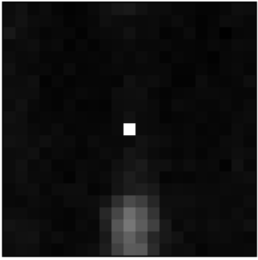

 Na první pohled je z datasetu zřejmé, že se zde opakuje jen několik málo souřadnic x a y, ale různé kombinace banků a sloupců, což by mohlo být způsobeno i chybou přístroje, který si však takový pixel sám zapsal do souboru jako fluorescenční značku, což může být podnětem pro další analýzu. Při hledání optimálních symetrických značek budou ale tyto záznamy vyřazeny.

In [ ]:
dfX = dfX[dfX.midRatio<3]

Poměry stran jsou uloženy jako poměr menší ku větší, takže budou vždy v rozmezí 0-1, kdy 1 je nejžádanější výsledek. Na histogramu níže lze vidět, že počet symetrických značek je značný a lze tedy vybrat pouze takové, které jsou zcela symetrické.

count    1748317.000000
mean           0.793540
std            0.140321
min            0.193708
25%            0.695962
50%            0.814159
75%            0.910334
max            1.000000
Name: sideRatio, dtype: object
median  0.8141592920353983


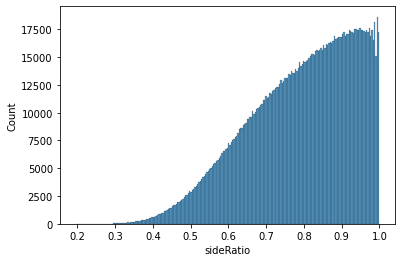

In [ ]:
print(dfX['sideRatio'].describe().apply(lambda x: format(x, 'f')))
print('median ', dfX['sideRatio'].median())
sns.histplot(data=dfX, x='sideRatio')

Odfiltrováním nesymetrických hodnot lze získat představu o poměru prostředních a okolních pixelů, průměrem je hodnota 1.1367 a medián je roven 1.1233.

In [ ]:
dfXSym = dfX[dfX.sideRatio == 1 ]
print('side ratio mean: ', dfXSym['midRatio'].mean())
print('side ratio median: ', dfXSym['midRatio'].median())

side ratio mean:  1.1366881923152137
side ratio median:  1.1232876712328768


Na grafu níže je zobrazeno rozdělení hodnot prostředního pixelu a poměrů mezi okolními pixely. Odfiltrováním byly odstraněny témeř všechny velmi jasné pixely až na jeden krajní případ, který má hodnotu intenzity okolo 3500 a poměr necelých 1.3. Velké množství pixelů má ale hodnotu, která může být zaměněna s šumem, je tedy provedeno poslední odfiltrování hodnot menších než 300.

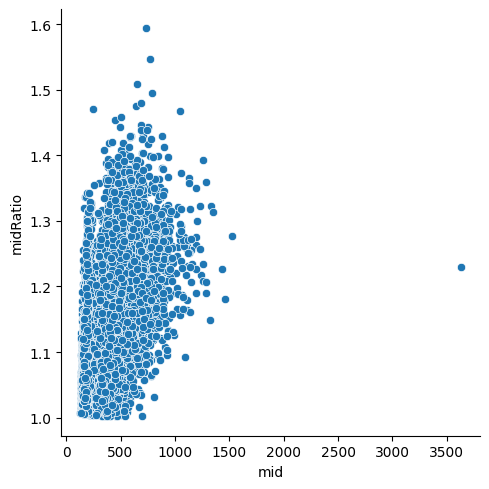

In [ ]:
sns.relplot(data=dfXSym, x="mid", y="midRatio")
dfXNoNoise = dfXSym[dfXSym.mid > 300]

Touto analýzou byly získány parametry, které nejen popisují fluorescenční značky v BNX souboru, ale také udávají parametry pro další spouštění vytvořeného skriptu hledajícího symetrické pixely, těmi jsou:

*   minimální poměr prostředního a okolních pixelů > 1
*   maximální poměr prostředního a okolních pixelů < 3
*   odfiltrování šumu s hodnotou < 300

Dalším poznatkem je fakt, že se symetrické značky v obrázku skutečně nacházejí a je tedy možné pracovat v další analýze s využitím pouze takových hodnot, které mají poměr okolních pixelů rovno jedné. Výsledným průměrem je 1.1764 a výsledným mediánem je 1.1725. 

Počet značek se tímto postupem redukoval z 2095878 na 4810.



In [ ]:
print('mean ', dfXNoNoise['midRatio'].mean())
print('median ', dfXNoNoise['midRatio'].median())
dfXNoNoise

mean  1.1763814804602766
median  1.1724936793497567


,x,y,left,mid,right,scan,run,column,midRatio,sideRatio,isFromBNX
1402,466,4843,320,419,320,1,1.5,12,1.309375,1.0,1
1810,760,5859,524,581,524,1,1.5,2,1.108779,1.0,1
2518,43,5931,397,499,397,1,1.5,6,1.256927,1.0,1
2786,151,4850,602,790,602,1,1.5,6,1.312292,1.0,1
3950,98,6644,307,352,307,1,1.5,16,1.146580,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2094811,957,6865,349,397,349,1,7.5,134,1.137536,1.0,1
2094819,320,6106,279,313,279,1,7.5,78,1.121864,1.0,1
2094841,704,5229,375,405,375,1,7.5,90,1.080000,1.0,1
2095370,836,4523,417,506,417,1,7.5,107,1.213429,1.0,1


Mediány jsou téměr shodné pro všechny banky (podle čísla runu) a lze jej tedy uvažovat jako vstup pro charakteristiku šíření světla ze značky. Pro osu x je tedy zvolen poměr **1.1725**.

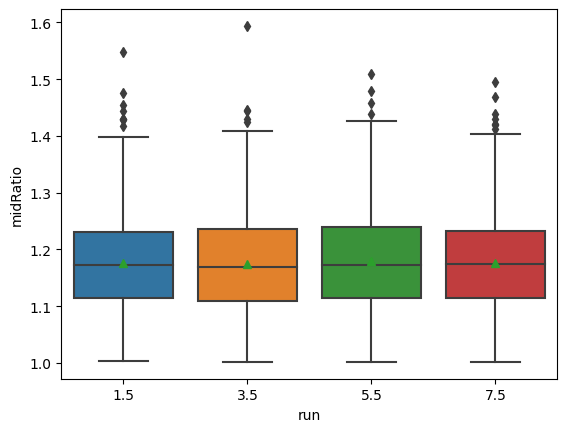

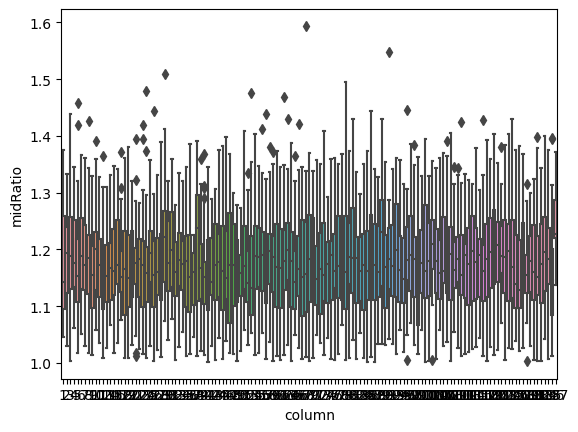

In [ ]:
sns.boxplot(data=dfXNoNoise, x='run', y='midRatio', showmeans=True)
plt.show()
sns.boxplot(data=dfXNoNoise, x='column', y='midRatio')
plt.show()

In [ ]:
dfXNoNoise['midRatio'].describe()

count    4810.000000
mean        1.176381
std         0.086665
min         1.001859
25%         1.112376
50%         1.172494
75%         1.234216
max         1.593886
Name: midRatio, dtype: float64

**Potencionální značky z obrázků**

Stejná analýza jako pro značky v souboru BNX proběhla také napříč všemi obrázky s dříve definovanými parametry, aby bylo možné porovnat, zda tyto dva přístupy určí stejný poměr prostředního pixelu a jeho okolí.

Plně symetrických značek splňujících stanovené parametry bylo nalezeno 191 178 (oproti 4000 v BNX). Průměr a medián se oproti BNX souboru snížily, a to poměrně znatelně, medián značek v BNX byl roven 1.17 a nyní je 1.08.

In [ ]:
dfXPot = pd.read_csv('data/x_images1_filtered.csv', sep=',', header=1)
print('mean ', dfXPot['midRatio'].mean())
print('median ', dfXPot['midRatio'].median())
print(len(dfXPot))

mean  1.109776715457672
median  1.089974293059126
191178


V případě obrázků je oproti BNX obsažen větší poměr hodnot, které dosahují menšího poměru mezi prostřední a okolními hodnotami. Po vizualizaci je patrné, že menší střední hodnoty jsou přítomny hlavně u obrázků na druhém banku, naopak nejvyšší střední hodnoty u obrázků na třetím banku. Je tedy na zvážení, zda při práci s hodnotami z obrázků nevytvářet charakteristiku jasu jen pro určité skupiny, například na základě banku/runu.

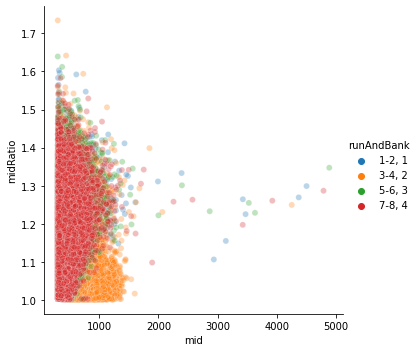

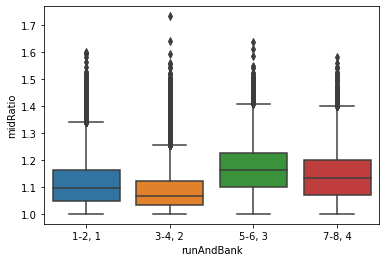

In [ ]:
dfXPot['runAndBank'] = ''
dfXPot.loc[dfXPot['run'] == 1.5, 'runAndBank'] = '1-2, 1'
dfXPot.loc[dfXPot['run'] == 3.5, 'runAndBank'] = '3-4, 2'
dfXPot.loc[dfXPot['run'] == 5.5, 'runAndBank'] = '5-6, 3'
dfXPot.loc[dfXPot['run'] == 7.5, 'runAndBank'] = '7-8, 4'
sns.relplot(data=dfXPot, x="mid", y="midRatio", hue='runAndBank', alpha=0.3)
plt.show()
sns.boxplot(data=dfXPot, x='runAndBank', y='midRatio')
plt.show()

Na základě analýzy jak BNX souboru scanu 1, tak všech obrázků scanu 1 se ukázalo, že BNX soubor má stabilní poměr hodnot prostředních k okolním pixelům u symetrixkých značek. V případě hodnot pouze z obrázků je sice nalezeno více symetrických značek, ale střední hodnoty hledaného poměru si nejsou ve všech případech podobné. Pro zjištění svítivosti je tedy vhodnější zvolit medián poměru hodnot prostředního a okolích pixelů symetrických značek ze souboru BNX, a to 1.1725 pro osu x a scan číslo 1.

# **Symetrie na ose Y**

**BNX soubor**

Při využití stejných parametrů stanovených v případě osy x, jsou střední hodnoty poměru hodnot prostředního a okolních pixelů téměr shodné, ale i zde lze pozorovat velmi mírný pokles v banku 2 (run 3 a 4) jako v případě potencionálních značek v obrázku.

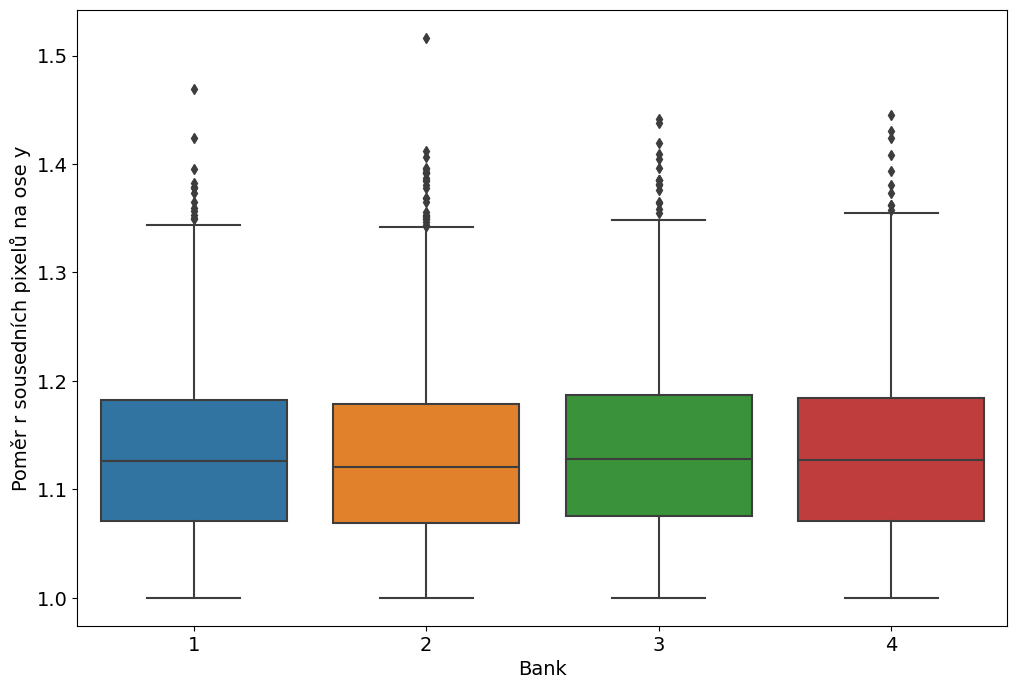

In [ ]:
dfY = pd.read_csv('data/y_BNX1_filtered.csv', sep=',', header=1)
dfY
labels = ['1','2','3','4']
plt.figure(figsize=(12, 8))
gfg = sns.boxplot(data=dfY, x='run', y='midRatio')
gfg.set(xlabel ="Bank", ylabel = "Poměr r sousedních pixelů na ose y")
gfg.xaxis.label.set_fontsize(14)
gfg.yaxis.label.set_fontsize(14)
gfg.set_xticklabels(labels)
gfg.tick_params(axis='both', which='major', labelsize=14)
plt.show()

Jako poměr mezi hodnotami středního a okolních pixelů bude pro osu x stanoven medián s hodnotou **1.1263**.

In [ ]:
print('mean ', dfY['midRatio'].mean())
print('median ', dfY['midRatio'].median())

mean  1.1330393043127216
median  1.1263048926664487


**Potencionální značky z obrázku**

Nápodobně jako u osy x zde vyplynul rozdíl mezi jednotlivými banky/runy, a to dokonce se stejným pořadím velikosti středních hodnot. 

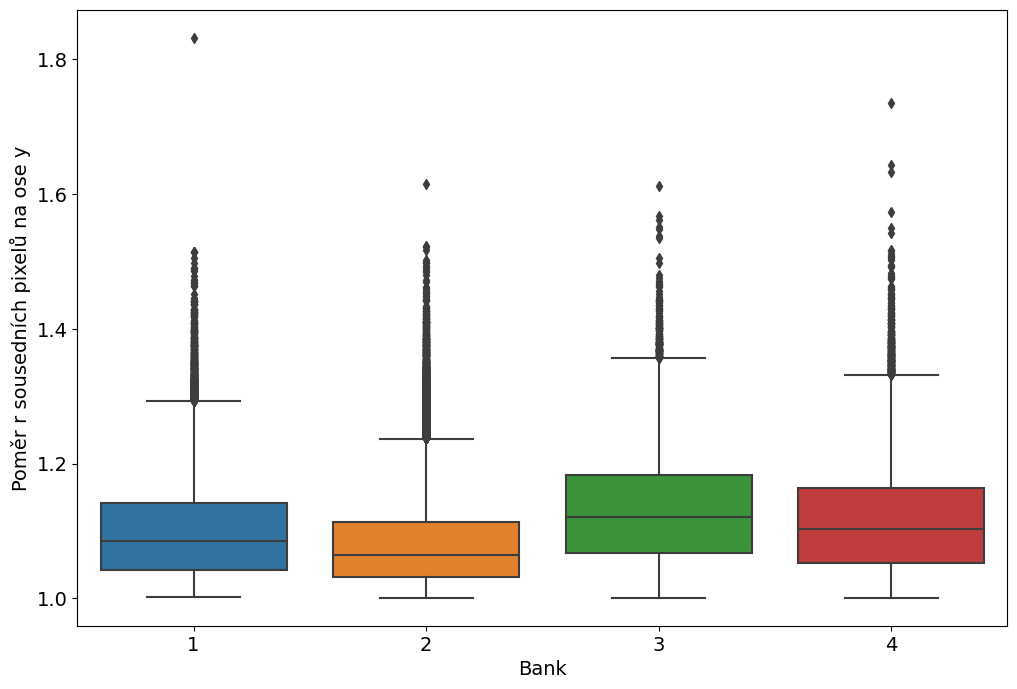

In [ ]:
dfYPot = pd.read_csv('data/y_images1_filtered.csv', sep=',', header=1)
dfYPot
labels = ['1','2','3','4']
plt.figure(figsize=(12, 8))
gfg = sns.boxplot(data=dfYPot, x='run', y='midRatio')
gfg.set(xlabel ="Bank", ylabel = "Poměr r sousedních pixelů na ose y")
gfg.xaxis.label.set_fontsize(14)
gfg.yaxis.label.set_fontsize(14)
gfg.set_xticklabels(labels)
gfg.tick_params(axis='both', which='major', labelsize=14)
plt.show()

Průměr a medián jsou oproti hodnotám nalezeným v BNX nižší. Avšak v porovnání s hodnotami nalezenými v obrázcích na ose x je medián vcelku podobný, ikdyž stále nižší. Osa y: 1.07877, osa x: 1.08997. 

In [ ]:
print('mean ', dfYPot['midRatio'].mean())
print('median ', dfYPot['midRatio'].median())

mean  1.0953055491383439
median  1.0787671232876712


**Symetrie na obou osách**

V případě výběru značek, které jsou symetrické jak na ose x, tak na ose y, je jich nalezeno pro scan 1 v BNX souboru pouze 24. Hodnoty těchto značek ale nebudou ovlivněny posunem na druhé ose při hledání posunu a stojí tedy za zvážení, zda nepoužít také tuto charakteristiku.
Mediány se lehce zvýšily a to na: osa x= 1.18216, y =1.14947.

**Závěr symetrie**

Z analýzy symetrických značek jak v BNX souboru, tak napříč všemi obrázky náležícími k souboru, vyplynulo, že symetrické značky nalezené dle BNX mají poměr hodnot prostředního a okolních pixelů neměnící se v závislosti na banku, narozdíl od značek ze všech obrázků, kde se nachází nejnižší medián těchto hodnot na banku 2. Tento jev by mohl symbolizovat větší přítomnost šumu a oddetekování falešných symetrických značek.

Poměry pixelů byly na ose x vyšší než na ose y v obou případech. To může být způsobeno například natažením molekuly v kanálku a tedy většího rozprostření šířeného světla.

Posledním poznatkem je, že v případě BNX byl rozdíl zvolených mediánů na obou osách vůči sobě větší, než v případě obrázků.
 $\frac{median_{yBNX}}{median_{xBNX}} = 0.96$

 $\frac{median_{yImage}}{median_{xImage}} = 0.98$

# **Posunutí symetrie na základě označeného nukleotidu**

Plně symetrický pixel a jeho okolí by měl symbolizovat fluorescenční značku, která má hledanou osvětlenou sekvenci nukleotidových bází (o délce maximálně 6) uprostřed všech nukleotidových bází zahrnutých v jednom pixelu(dohromady 375 na každé ose). Výskyt osvětlené sekvence mimo střed způsobí vychýlení symetrie značky. Za předpokladu že intenzity šíření tohoto osvětlení lze modelovat normální rozdělením byl vytvořen systém určení posunu osvětlené sekvence nukleotidové báze od středu. 

Hodnoty ideálního poměru mezi prostředním a okolními pixely byly využity k nalezení normálního rozdělení takového, kde jedna jednotka osy x odpovídá velikosti jednoho pixelu. Tedy prostřední pixel bude popsán v případě střední hodnoty rovné 0 v rozmezí < -0.5, 0.5 >, okolní pixely v rozmezí < -1.5, -0,5> a < 0.5, 1.5>. Poměr pravděpodobností těchto rozmezí pak bude odpovídat poměru pixelů vůči sobě. Je tedy hledána odpovídající směrodatná odchylka, aby rozdělení splňovalo $\frac{P(-\frac{1}{2}<X<\frac{1}{2})}{P(-\frac{3}{2}<X<-\frac{1}{2})} = \frac{intensity_{mid}}{intensity_{left}}$.

Prvním krokem bylo nalézt parametr K takový, který bude vypovídat o tom, kolik jednotek na ose x zabírá rozmezí jednoho pixelu v normálním rozdělení *N(0,1)*, aby splňoval předpoklad, že se budou poměry pravděpodobností rozpětí prostředního a jednoho z vedlejších pixelů (rozdělení je symetrické a na straně nezáleží) rovnat poměru hodnot intenzit pixelů, která byla stanovena v předchozím kroku. Z parametru K již lze jednoduše získat normalizací směrodatnou odchylku, která se rovná jeho převrácené hodnotě, a je tak dosáhnuto velikosti pixelu rovné jedné jednotce na ose x. Takto získané normální rozdělení popisuje šíření jasu pixelu mezi jeho okolí a umožňuje zjistit hodnotu jasu pro jednotlivou sekvenci. 

Posunutím střední hodnoty vytvořeného rozdělení lze porovnáním poměru pravděpodobností pro rozpětí prostředního pixelu (v tomto případě se již vždy 1 pixel rovná 1 jednotce osy x) a vedlejšího pixelu s poměrem hodnot prostředního pixelu a jednoho z pixelů v okolí získat počet nukleotidových bází o který je značka posunuta a kterým směrem. Střední hodnota musí být vybírána s ohledem na nukleotidové báze, tedy jeden krok = $\frac{1}{375}$. Zvolena je taková střední hodnota, kde bude rozdíl poměrů mezi pravděpodobností a hodnotou pixelů nejměnší. Otázkou zůstává, zda zohledňovat pouze rozdíl posunu na stranu s vyšší hodnotou intenzity pixelu nebo rozdíl jak zvětšené tak zmenšené hodnoty.

**Osa X:**

In [ ]:
CHOSEN_MID_RATIO_X = 1.1725

In [ ]:
kX = getK(CHOSEN_MID_RATIO_X)
print('Velikost jednoho pixelu na ose X (parametr K) =', kX)

Velikost jednoho pixelu na ose X (parametr K) = 0.5720000000000004


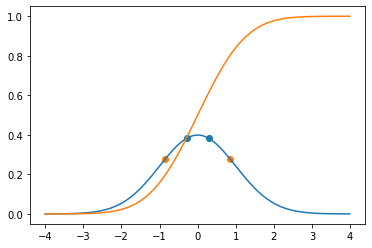

In [ ]:
plotNormalDistributionWithPointsByK(kX)

Z parametru K je zjištěna směrodatná odchylka, čímž vznikne hledané normální rozdělení na popis rozptylu světla.

In [ ]:
devX = getSigmaFromK(kX)
print('Odchylka normálního rozdělení na ose X: ', devX)

Odchylka normálního rozdělení na ose X:  1.748251748251747


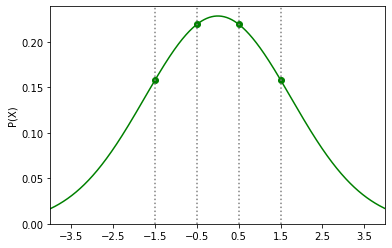

In [ ]:
plotNormalDistributionWithStaticPoints(kX)

**Osa y:**

In [ ]:
CHOSEN_MID_RATIO_Y = 1.1263

In [ ]:
kY = getK(CHOSEN_MID_RATIO_Y)
print('Velikost jednoho pixelu na ose Y (parametr K) =', kY)

Velikost jednoho pixelu na ose Y (parametr K) = 0.4920000000000004


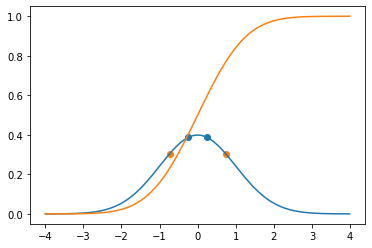

In [ ]:
plotNormalDistributionWithPointsByK(kY)

In [ ]:
devY = getSigmaFromK(kY)
print('Odchylka hledaného rozdělení na ose Y: ', devY)

Odchylka hledaného rozdělení na ose Y:  2.0325203252032504


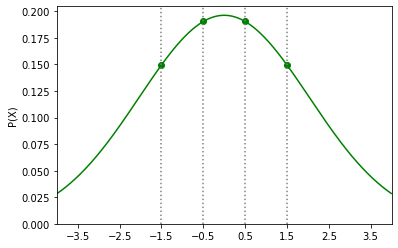

In [ ]:
plotNormalDistributionWithStaticPoints(kY)

**Porovnání šíření světla na obou osách:**

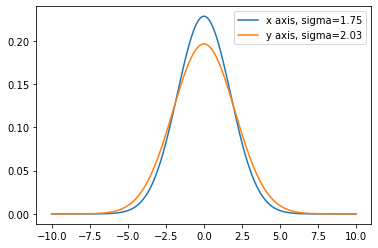

In [ ]:
rangeS,rangeE = -10,10
range = np.arange(rangeS, rangeE, 0.01)
normalizedX = norm.pdf(range, MEAN, devX)
normalizedY = norm.pdf(range, MEAN, devY)
plt.plot(range, normalizedX, label='x axis, sigma=' + str(round(devX,2)))
plt.plot(range, normalizedY, label = 'y axis, sigma=' + str(round(devY, 2)))
plt.legend()
plt.show()

Na ose y vzniká větší směrodatná odchylka, což znamená že vetrikálně jsou si pixely na okolních stranách hodnotami bližší s prostředními, než na ose x.

# **Results**

note: calculatedDistance is incorrect (expectedDistance+shift), should be expextedDistance%375 + calculatedY

In [ ]:
df=pd.read_csv('data/horizontal_mask_scan_1.csv', header=1)

drop marks without center in the middle (bad reading of bnx)

In [ ]:
df["intensityDiff"] = np.where(df[" 'up'"] >= df[" 'down'"], df["'mid'"] - df[" 'up'"], df["'mid'"] - df[" 'down'"])

In [ ]:
df = df.loc[(df["'mid'"]>df[" 'up'"]) & (df["'mid'"]>df[" 'down'"])]

In [ ]:
df

,'mid','left','right','up','down','calculatedX','expectedDistance','calculatedDistance','expectedY','calculatedY',intensityDiff
0,924,939,558,793,747,180.0,5368,5360.5,118,180.0,131
1,506,530,348,408,486,180.0,7832,7962.0,332,317.5,20
2,730,766,492,605,633,180.0,14052,14052.0,177,187.5,97
3,704,620,518,587,635,110.0,21249,21299.0,249,237.5,69
4,621,561,469,600,605,180.0,23658,23808.0,33,337.5,16
...,...,...,...,...,...,...,...,...,...,...,...
939,584,495,496,486,490,257.5,20057,20057.0,182,187.5,94
940,606,431,532,568,445,367.5,25526,25418.5,26,80.0,38
941,1050,795,967,1032,841,317.5,27796,27638.5,46,30.0,18
942,736,553,696,588,718,297.5,31077,31227.0,327,337.5,18


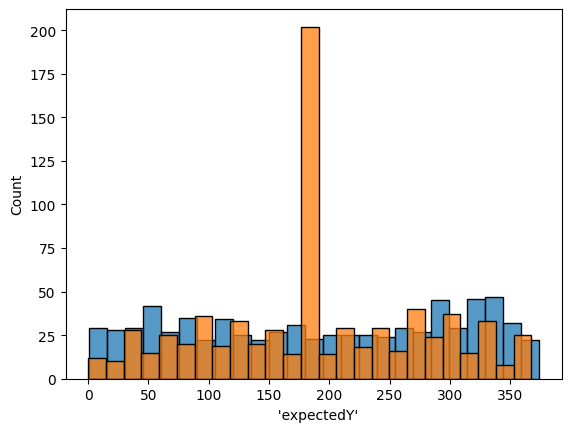

In [ ]:
sns.histplot(data=df,bins=25, x="  'expectedY'")
sns.histplot(data=df, bins=25,x=" 'calculatedY'")

plt.show()

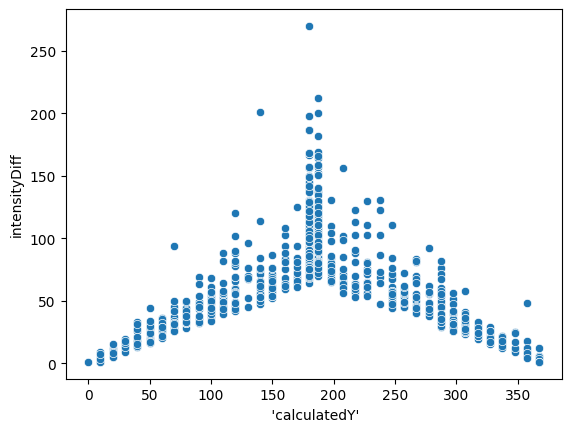

In [ ]:
sns.scatterplot(data=df, x=" 'calculatedY'", y="intensityDiff")
plt.show()

In [ ]:
df["diff"] = df[" 'calculatedY'"] - df["  'expectedY'"]

In [ ]:
abs(df["diff"]).describe()

count    750.000000
mean      62.852000
std       51.880107
min        0.000000
25%       21.000000
50%       50.750000
75%       91.000000
max      321.500000
Name: diff, dtype: float64

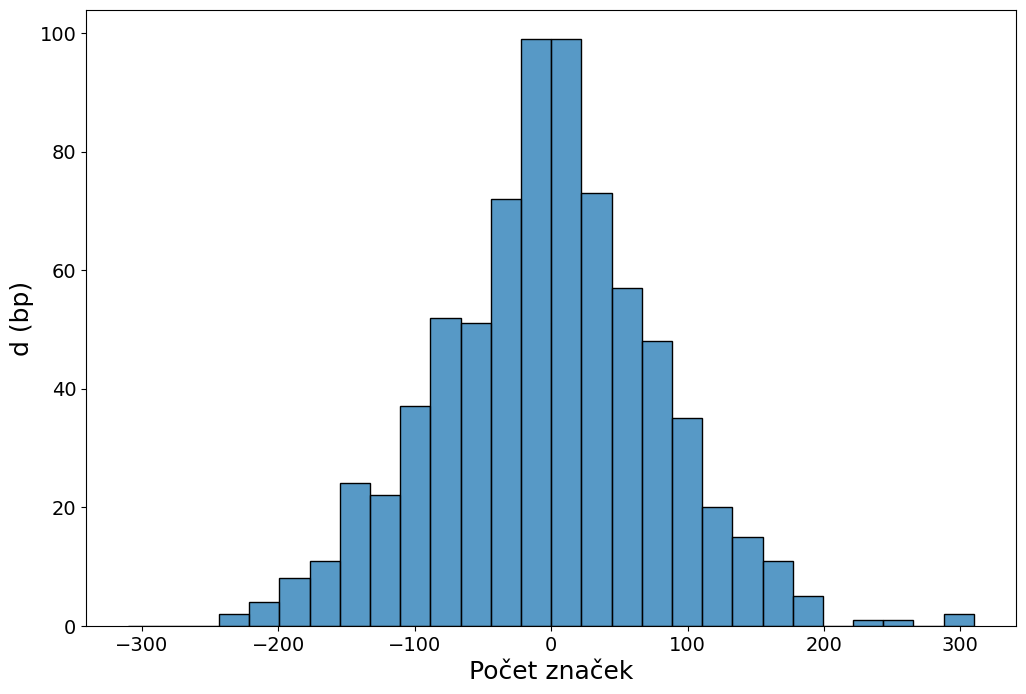

In [ ]:
plt.figure(figsize=(12, 8))
gfg = sns.histplot(data=df, x='diff',binrange=(-310,310))
gfg.set(xlabel ="Počet značek", ylabel = "d (bp)")
gfg.xaxis.label.set_fontsize(18)
gfg.yaxis.label.set_fontsize(18)
gfg.tick_params(axis='both', which='major', labelsize=14)
plt.show()

<Axes: xlabel="'mid'", ylabel='diff'>

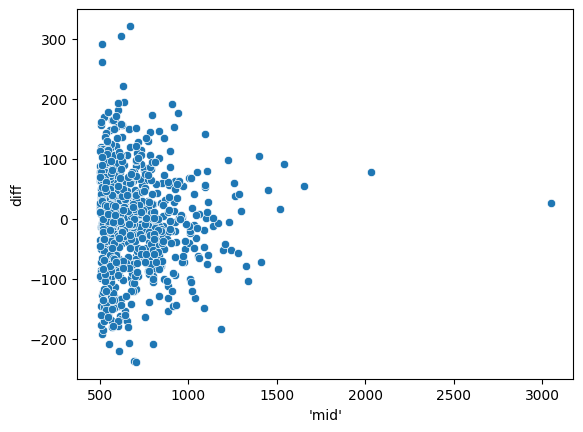

In [ ]:
sns.scatterplot(data=df, x="'mid'", y="diff")

# **Center of mass**

In [ ]:
df=pd.read_csv('data/centerOfMass_full_scan_1.csv', header=1)
df[" 'expectedY'"] = df[" 'expectedY'"] % 375
df["diff"] = df["'calculatedY'"] - df[" 'expectedY'"]
df

,'calculatedY','expectedY','calculatedX','shape',diff
0,181.400839,149,142.740031,c,32.400839
1,183.828029,149,102.413556,s,34.828029
2,184.711205,213,150.873823,c,-28.288795
3,186.287834,213,132.511754,s,-26.712166
4,191.147860,374,168.044747,c,-182.852140
...,...,...,...,...,...
41943,174.284141,82,180.396476,s,92.284141
41944,183.367347,81,189.642857,c,102.367347
41945,178.723404,81,197.783688,s,97.723404
41946,178.947695,201,177.460337,c,-22.052305


<Axes: xlabel="'calculatedY'", ylabel='Count'>

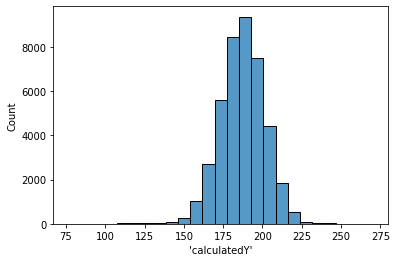

In [ ]:
sns.histplot(data=df, bins=25,x="'calculatedY'")

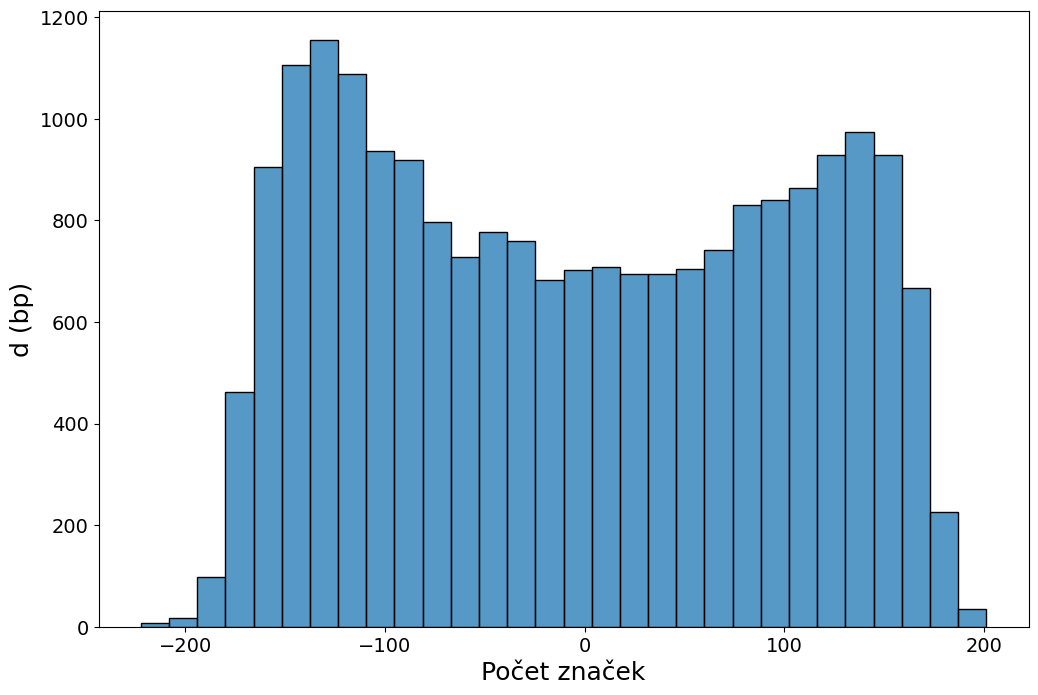

In [ ]:
plt.figure(figsize=(12, 8))
gfg = sns.histplot(data=df.loc[df[" 'shape'"] == 'c'], x='diff')
gfg.set(xlabel ="Počet značek", ylabel = "d (bp)")
gfg.xaxis.label.set_fontsize(18)
gfg.yaxis.label.set_fontsize(18)
gfg.tick_params(axis='both', which='major', labelsize=14)
plt.show()

<Axes: xlabel='diff', ylabel='Count'>

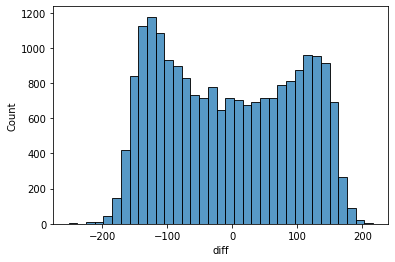

In [ ]:
sns.histplot(data=df.loc[df[" 'shape'"] == 's'], x='diff')

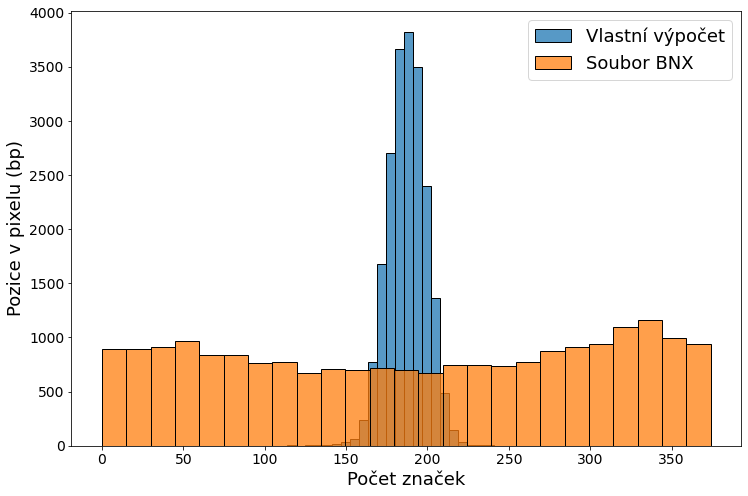

In [ ]:
plt.figure(figsize=(12, 8))
gfg = sns.histplot(data=df.loc[df[" 'shape'"] == 'c'], bins=25,x="'calculatedY'", label='Vlastní výpočet')
sns.histplot(data=df.loc[df[" 'shape'"] == 'c'],bins=25, x=" 'expectedY'", label='Soubor BNX')
gfg.set(xlabel ="Počet značek", ylabel = "Pozice v pixelu (bp)")
gfg.xaxis.label.set_fontsize(18)
gfg.yaxis.label.set_fontsize(18)
gfg.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=18)
plt.show()